In [43]:
#Import dependencies

import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd # for csv.
from matplotlib import cm
from matplotlib.lines import Line2D
import os
from os.path import exists,split,join,splitext
from os import makedirs
import glob
import requests
from collections import defaultdict
import nrrd
import torch
from torch.nn.functional import grid_sample
import tornado
from STalign import STalign
import copy
import skimage as ski
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# loading the allen atlas
url = 'http://api.brain-map.org/api/v2/data/query.csv?criteria=model::Structure,rma::criteria,[ontology_id$eq1],rma::options[order$eq%27structures.graph_order%27][num_rows$eqall]'
ontology_name,namesdict = STalign.download_aba_ontology(url, 'allen_ontology.csv') #url for adult mouse

imageurl = 'http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/ara_nissl/ara_nissl_50.nrrd'
labelurl = 'http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/annotation_50.nrrd'
imagefile, labelfile = STalign.download_aba_image_labels(imageurl, labelurl, 'aba_nissl.nrrd', 'aba_annotation.nrrd')

<Response [200]>


In [44]:
# Open image
filename = 'data_images\hyopil_3.jpg'
W = ski.io.imread(filename)
print(W.shape)

(4393, 3104, 3)


Pre-Processing

In [45]:
W_ = np.max(W) - W
W_ = ski.color.rgb2gray(W_) #then to gray scale
W_ = (W_ - np.min(W_))/(np.max(W_) - np.min(W_)) #then normalize

(4393, 3104)


<IPython.core.display.Javascript object>


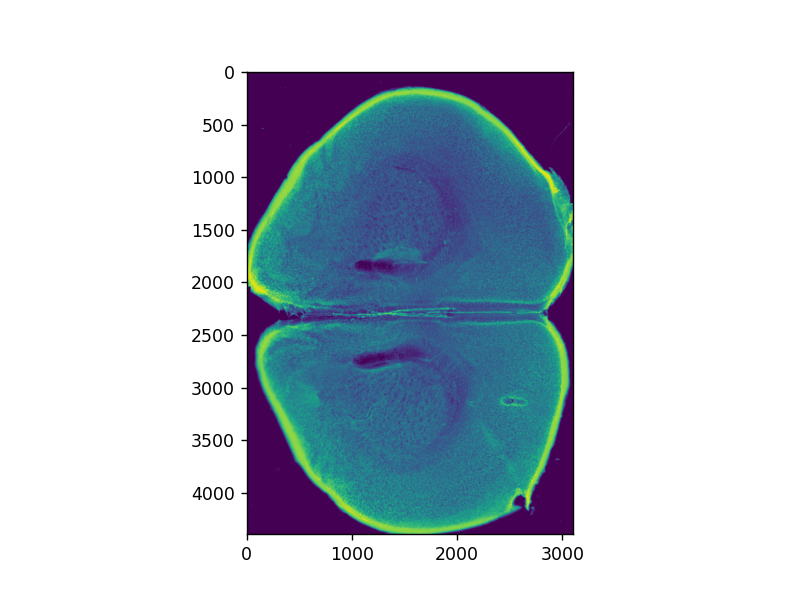

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [46]:
# manually set the bright squares to 0
W__ = np.copy(W_)
W__[:1250,3067:] = 0
W__[2040:,:35] = 0
print(W__.shape)

fig,ax = plt.subplots()
plt.imshow(W__)
print(W__[2040:,:35])

<IPython.core.display.Javascript object>


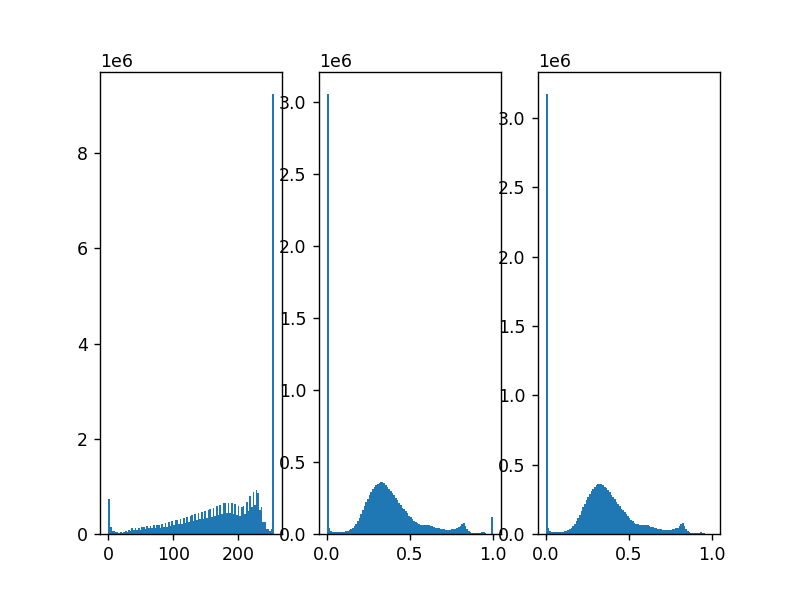

(array([3.173825e+06, 4.139600e+04, 2.386300e+04, 1.464500e+04,
        1.320200e+04, 1.323500e+04, 1.358100e+04, 1.390900e+04,
        1.445600e+04, 1.532900e+04, 1.679600e+04, 1.879200e+04,
        2.236500e+04, 2.781100e+04, 3.418800e+04, 4.334700e+04,
        5.567800e+04, 7.092300e+04, 9.093300e+04, 1.144100e+05,
        1.396980e+05, 1.662970e+05, 1.929070e+05, 2.192150e+05,
        2.440170e+05, 2.701400e+05, 2.910570e+05, 3.120670e+05,
        3.271420e+05, 3.394670e+05, 3.499450e+05, 3.575700e+05,
        3.606080e+05, 3.588420e+05, 3.551610e+05, 3.400900e+05,
        3.291400e+05, 3.158900e+05, 3.009450e+05, 2.833820e+05,
        2.691340e+05, 2.501330e+05, 2.335280e+05, 2.139870e+05,
        1.993220e+05, 1.834100e+05, 1.708280e+05, 1.571970e+05,
        1.428410e+05, 1.281640e+05, 1.150910e+05, 1.026840e+05,
        9.172400e+04, 8.140500e+04, 7.394700e+04, 6.898500e+04,
        6.575300e+04, 6.460400e+04, 6.413500e+04, 6.335400e+04,
        6.473600e+04, 6.231400e+04, 5.69

In [47]:
# Intensity Histogram
fig,ax = plt.subplots(1,3)
ax[0].hist(W.ravel(),bins=100)
ax[1].hist(W_.ravel(),bins=100)
ax[2].hist(W__.ravel(),bins=100)

<IPython.core.display.Javascript object>


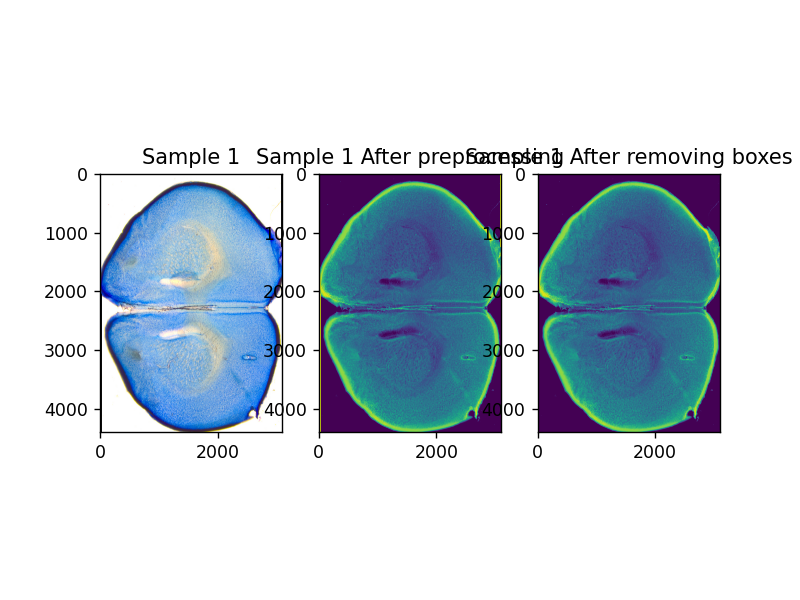

Text(0.5, 1.0, 'Sample 1 After removing boxes')

In [48]:
# Display image
fig,ax = plt.subplots(1,3)
ax[0].imshow(W,  origin='lower')
ax[0].invert_yaxis()
ax[0].set_title('Sample 1')

ax[1].imshow(W_,  origin='lower')
ax[1].invert_yaxis()
ax[1].set_title('Sample 1 After preprocessing')

ax[2].imshow(W__,  origin='lower')
ax[2].invert_yaxis()
ax[2].set_title('Sample 1 After removing boxes')

(4393, 3104)
(5793, 4504)


<IPython.core.display.Javascript object>


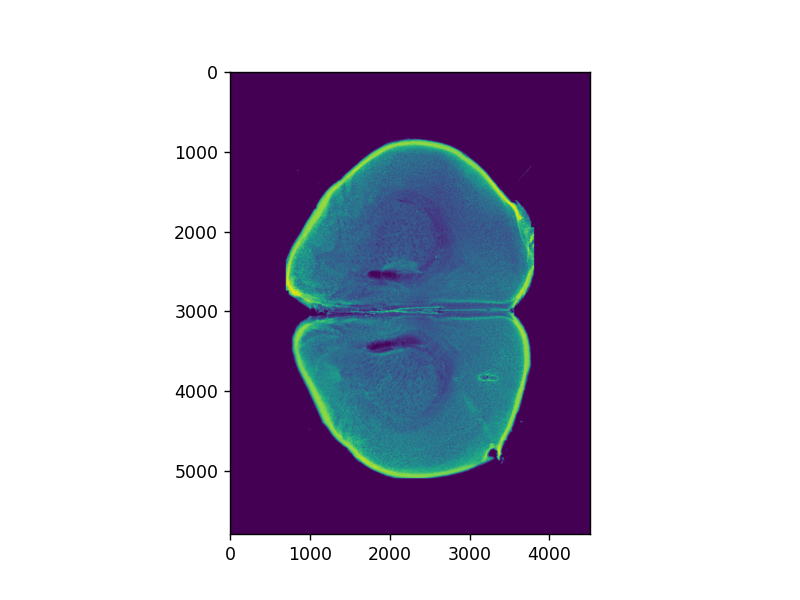

In [60]:
#padding with 100 col/rows of background
Wpad = np.pad(W__,((700,700),(700,700)),'constant',constant_values=0)

print(W__.shape)
print(Wpad.shape)

'''
#now pad so aspect ratio matches Allen Atlas slice
print(A[slice].shape)
Aratio = A[slice].shape[0]/A[slice].shape[1] #height/width ratio of A[slice]
Wratio = Wpad.shape[0]/Wpad.shape[1] #height/width ratio of Wpad


Padding to make it more aesthetic *ignore*
if (Aratio == Wratio):
    print('good')
elif (Aratio > Wratio):
    print('we must pad top/bottom')
    pad_amt = int(((Wpad.shape[1] * Aratio) - Wpad.shape[0])/2)
    Wpad = np.pad(Wpad,((pad_amt,pad_amt),(0,0)),'constant',constant_values=0)
else:
    print('we must pad left/right')
    pad_amt = int(((Wpad.shape[0] / Aratio) - Wpad.shape[1])/2)
    Wpad = np.pad(Wpad,((0,0),(pad_amt,pad_amt)),'constant',constant_values=0)

print(Wpad.shape)
print(Aratio,(Wpad.shape[0]/Wpad.shape[1]))
'''

fig,ax = plt.subplots()
ax.imshow(Wpad)

<IPython.core.display.Javascript object>


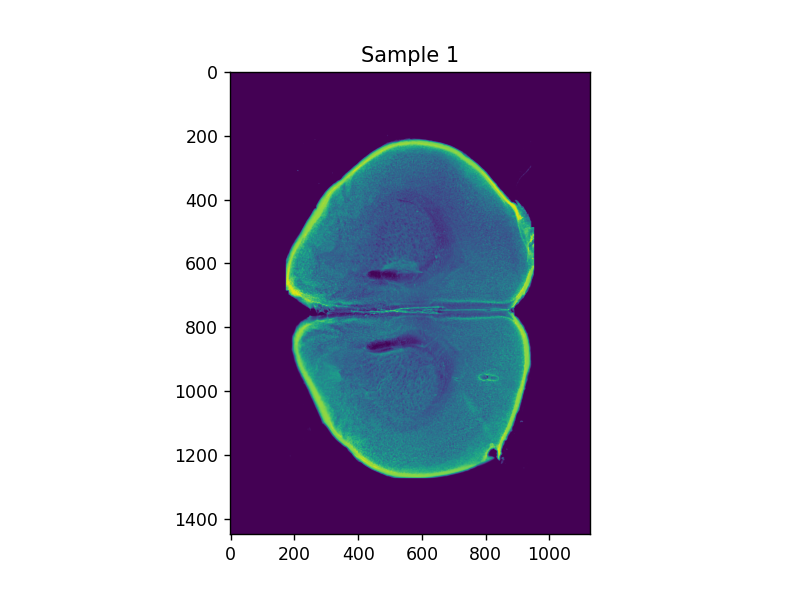

Text(0.5, 1.0, 'Sample 1')

In [61]:
W = ski.transform.downscale_local_mean(Wpad, (4,4)) # downsample
X_ = np.arange(0,W.shape[0])
Y_ = np.arange(0,W.shape[1])

# Display image
fig,ax = plt.subplots()
ax.imshow(W,  origin='lower')
ax.invert_yaxis()
ax.set_title('Sample 1')


Prep for STalign

<IPython.core.display.Javascript object>


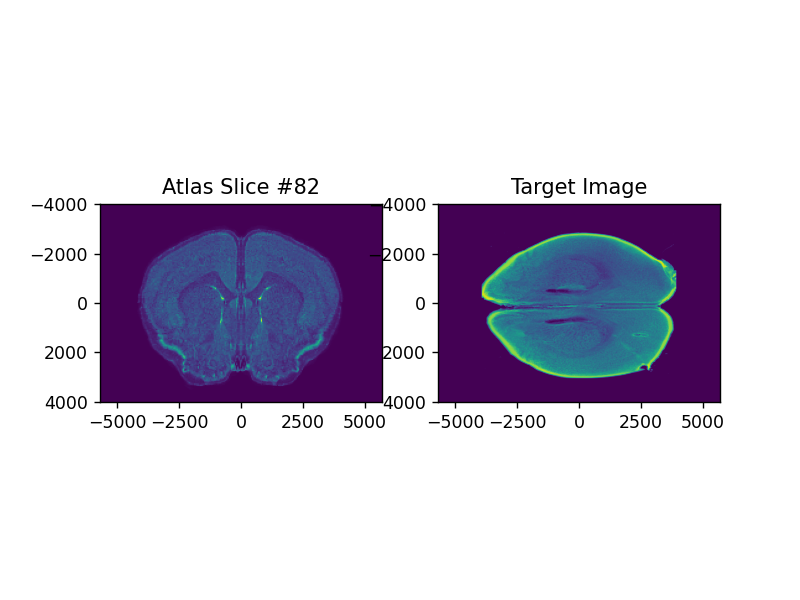

In [82]:
#find slice
#peruse through images in atlas
# Loading the atlas
import time

# stalign seems to use slice+10, not sure why
slice = 82


vol,hdr = nrrd.read(imagefile)
A = vol
vol,hdr = nrrd.read(labelfile)
L = vol

dxA = np.diag(hdr['space directions'])
nxA = A.shape
xA = [np.arange(n)*d - (n-1)*d/2.0 for n,d in zip(nxA,dxA)]
XA = np.meshgrid(*xA,indexing='ij')

fig,ax = plt.subplots(1,2)
extentA = STalign.extent_from_x(xA[1:])
ax[0].imshow(A[slice],extent=extentA)
ax[0].set_title(f'Atlas Slice #{slice}')

ax[1].imshow(W,extent=extentA)
ax[1].set_title('Target Image')
fig.canvas.draw()

<IPython.core.display.Javascript object>


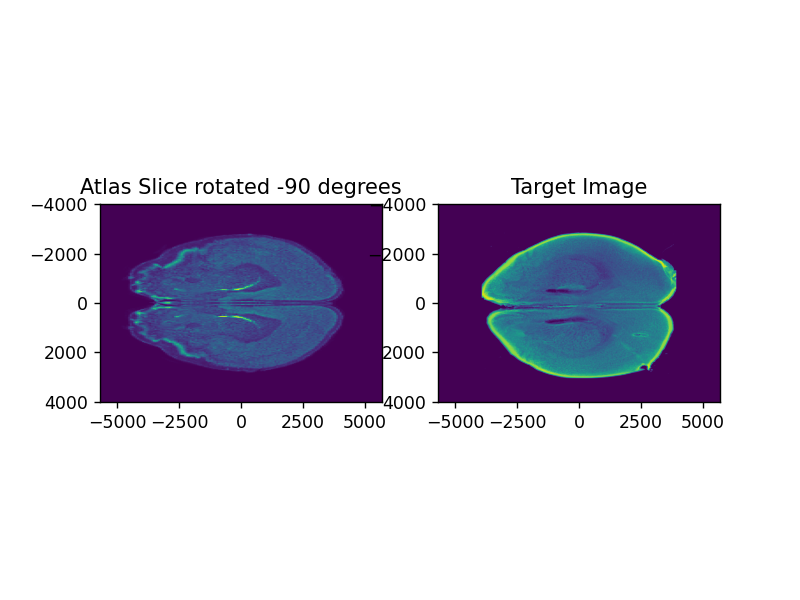

In [63]:
#find rotation
from scipy.ndimage import rotate

theta_deg = -90

fig,ax = plt.subplots(1,2)
extentA = STalign.extent_from_x(xA[1:])
ax[0].imshow(rotate(A[slice], angle=theta_deg),extent=extentA)
ax[0].set_title(f'Atlas Slice rotated {theta_deg} degrees')

ax[1].imshow(W,extent=extentA)
ax[1].set_title('Target Image')
fig.canvas.draw()

In [64]:
xJ = [Y_,X_]
J = W[None]/np.mean(np.abs(W))
xI = xA
I = A[None] / np.mean(np.abs(A),keepdims=True)
I = np.concatenate((I,(I-np.mean(I))**2))

<IPython.core.display.Javascript object>


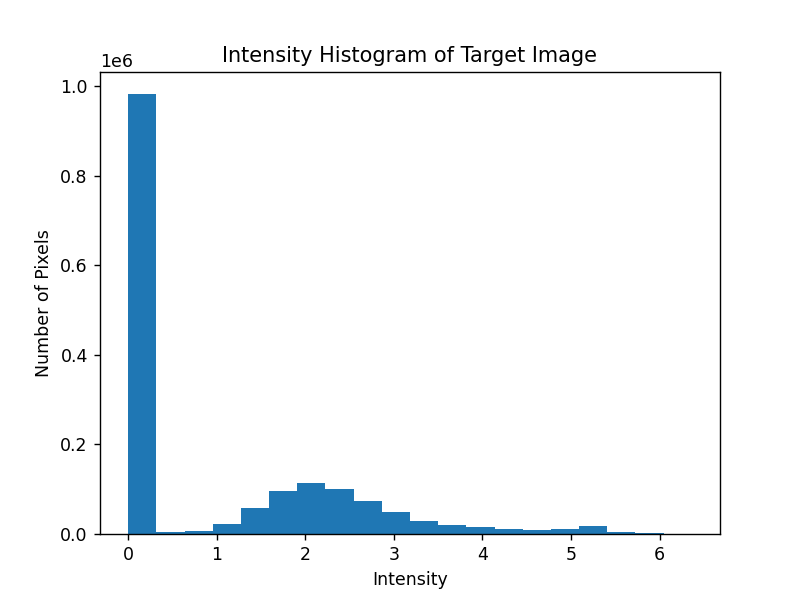

Text(0.5, 1.0, 'Intensity Histogram of Target Image')

In [67]:
# Intensity Histogram
fig,ax = plt.subplots()
ax.hist(J.ravel(), bins=20)
plt.xlabel('Intensity')
plt.ylabel('Number of Pixels')
plt.title('Intensity Histogram of Target Image')

In [68]:
sigmaA = .5 #standard deviation of artifact intensities
sigmaB = .2 #standard deviation of background intensities
sigmaM = 1 #standard deviation of matching tissue intenities

muA = torch.tensor([5,5,5],device='cpu') #average of artifact intensities

muB = torch.tensor([0,0,0],device='cpu') #average of background intensities
print(muA,muB);

tensor([5, 5, 5]) tensor([0, 0, 0])


In [69]:

slice += 2 # correcting for offset

In [75]:
# initialize variables
scale_x = 0.15 #default = 0.9
scale_y = 0.1 #default = 0.9
scale_z = 0.9 #default = 0.9
theta0 = (np.pi/180)*theta_deg
xJ = [Y_,X_]


# get an initial guess
if 'Ti' in locals():
    T = np.array([-xI[0][slice],np.mean(xJ[0])-(Ti[0]*scale_y),np.mean(xJ[1])-(Ti[1]*scale_x)])
else:
    T = np.array([-xI[0][slice],np.mean(xJ[0]),np.mean(xJ[1])])

scale_atlas = np.array([[scale_z,0,0],
                        [0,scale_x,0],
                        [0,0,scale_y]])
L = np.array([[1.0,0.0,0.0],
             [0.0,np.cos(theta0),-np.sin(theta0)],
              [0.0,np.sin(theta0),np.cos(theta0)]])
L = np.matmul(L,scale_atlas)#np.identity(3)

Actually Running STalign

<IPython.core.display.Javascript object>


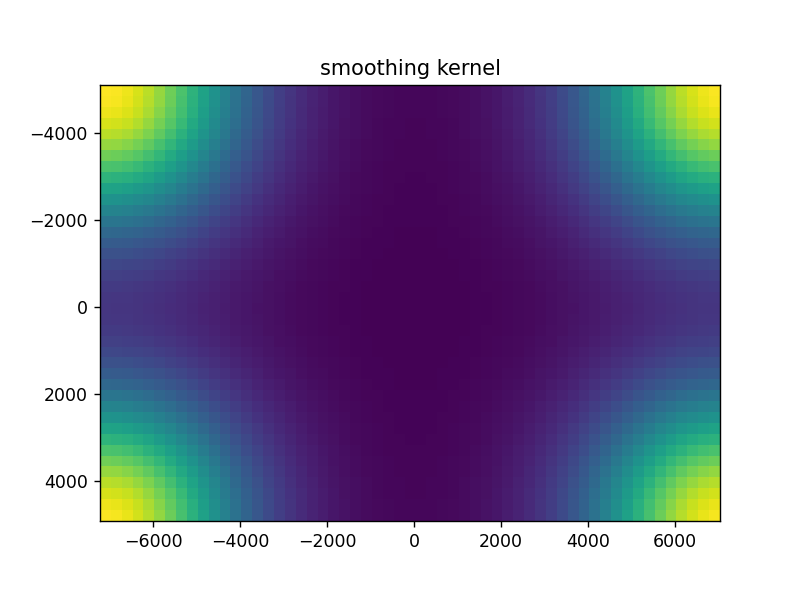

<IPython.core.display.Javascript object>


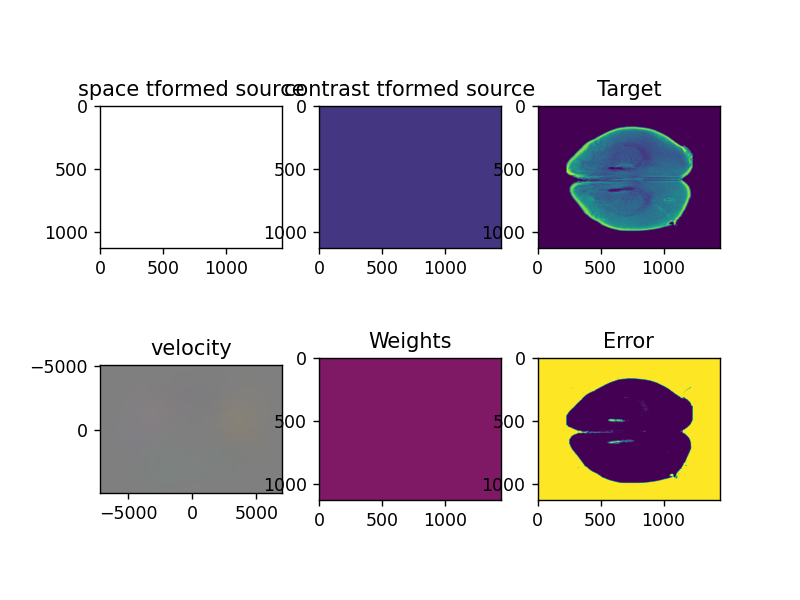

<IPython.core.display.Javascript object>


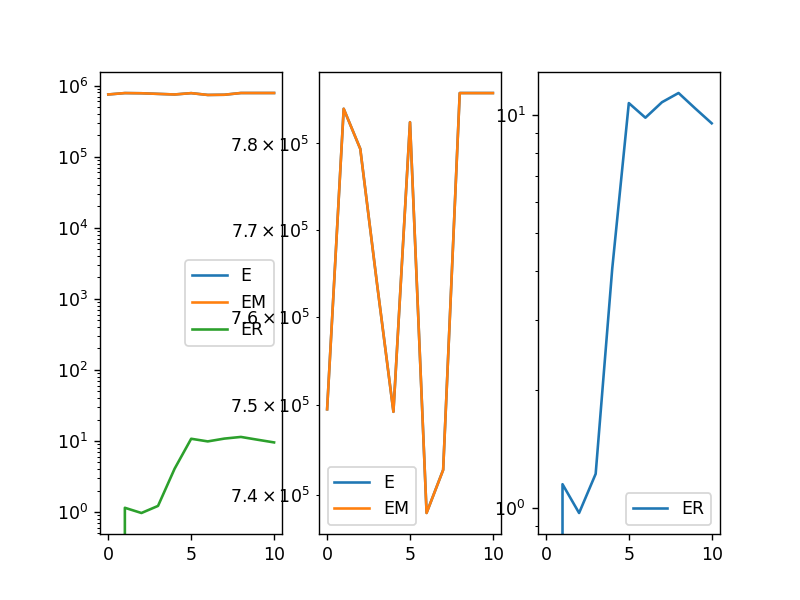

KeyboardInterrupt: 

In [81]:
%%time

# run LDDMM
# specify device (default device for STalign.LDDMM is cpu)
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'

#returns mat = affine transform, v = velocity, xv = pixel locations of velocity points
transform = STalign.LDDMM_3D_to_slice(
    xI,I,xJ,J,
    T=T,L=L,
    nt=4,niter=100,
    device='cpu',
    sigmaA = sigmaA, #standard deviation of artifact intensities
    sigmaB = sigmaB, #standard deviation of background intensities
    sigmaM = sigmaM, #standard deviation of matching tissue intenities
    muA = muA, #average of artifact intensities
    muB = muB #average of background intensities
    
)

In [79]:
# Saving all relavant variables
%store transform
%store xJ
print("stored")

Stored 'transform' (dict)
Stored 'xJ' (list)
stored


In [37]:
print(slice)

82
